# Simulate the Effects of Moon Wobble

The purpose of this notebook is to simulate the effects of a periodic moon wobble phenominon.

After considering a number of simulation methods, we decide to use the method proposed by [this paper](https://www.nature.com/articles/s41558-021-01077-8), and the simulation part of our code is therefore similar to [the code](https://github.com/philiprt/us-htf-projections/tree/v1.2) used by the linked paper.

This notebook has been tested and runs successfully on

Authors: 

## Import Packages and Define Support Functions

Please first ensure that you have all modules installed in your environment.

In [2]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

from multiprocessing import Pool
from typing import List
from tqdm import tqdm
import datetime as dt
import pandas as pd
import numpy as np
import pymc3 as pm
import requests
import pickle
import utide
import json
import os

#------------------------------------------------------------------------------
#unfinished
def get_station_name(sta_id, path=save_path+f'{country}/') -> List[str]:
    df = pd.read_pickle(path+'station_info.pickle')
    return 

## Configs

**save_path**: The directory from which the downloaded and calculated files will be saved and loaded from.

In [3]:
save_path = './' 
country = 'us'
station_ids = [1612340, 8443970, 8658120]

## 1. Downloading Data

US tidal gauge data is provided by

UK tidal gauge data is provided by

In [11]:
def download_us_data(ids, out_path=save_path+'us/'):
    os.makedirs(out_path, exist_ok=True)
    
    print('Downloading station information...')
    
    if ids:
        stations = []
        for i in ids:
            url = f'https://api.tidesandcurrents.noaa.gov/mdapi/prod/webapi/stations/{i}.json'
            stations += json.loads(requests.get(url).text)['stations']
            
    else:
        url = 'https://api.tidesandcurrents.noaa.gov/mdapi/prod/webapi/stations.json'
        stations = json.loads(requests.get(url).text)['stations']
        
    stations = [s for s in stations if s['tidal'] & ~s['greatlakes']]
    keys = ['name','id', 'lat', 'lng']
    meta = pd.DataFrame([list(map(s.get, keys)) for s in stations], 
                        columns=keys)
    with open(out_path+'station_meta.pickle', 'wb') as f:
        pickle.dump(meta, f)
    
    #--------------------------------------------------------------------------
    
    print('Downloading tidal data...')
    
    url_base = 'https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?'
    url_end = 'product=hourly_height&datum=MHHW&units=metric&time_zone=gmt&format=json'
    
    for i, sta in enumerate(stations):
        url_id = f'station={sta["id"]}&'
        desc = f'({i+1}/{len(stations)}){sta["name"]}_{sta["id"]}'
        
        datas = []
        for yr in tqdm(range(1900, 2022), desc=desc):
            url_date = f'begin_date={yr}0101&end_date={yr}1231&'
            url = url_base + url_date + url_id + url_end
            data = json.loads(requests.get(url).text)
            if 'error' in data:
                continue
            else:
                datas += data['data']
        
        obss = [d['v'] if d['v'] else None for d in datas]
        ts = [d['t'] for d in datas]
        df = pd.DataFrame(obss, 
                          dtype=np.float16, 
                          index=pd.to_datetime(ts), 
                          columns=['obs'])
        df.index.names = ['time']
        
        sta_path = out_path + f'{sta["id"]}/'
        os.makedirs(sta_path, exist_ok=True)
        with open(sta_path+'tide_guage.pickle','wb') as f:
            pickle.dump(df, f)
            
    print('Download finished')

#------------------------------------------------------------------------------

def download_uk_data(ids, out_path=save_path+'uk/'):
    pass
    # os.makedirs(out_path, exist_ok=True)
    
    # print('Downloading station information...')
    
    # url_base = 'https://environment.data.gov.uk/flood-monitoring/id/stations'
    
    # if ids:
    #     stations = []
    #     for i in ids:
    #         url = url_base + f'/{i}'
    #         stations += json.loads(requests.get(url).text)['items']
            
    # else:
    #     url = url_base + '?type=TideGauge'
    #     stations = json.loads(requests.get(url).text)['items']
        
    # keys = ['label','stationReference', 'lat', 'long']
    # meta = pd.DataFrame([list(map(s.get, keys)) for s in stations], 
    #                     columns=keys)
    # with open(out_path+'station_meta.pickle', 'wb') as f:
    #     pickle.dump(meta, f)
    
    #--------------------------------------------------------------------------
    

#------------------------------------------------------------------------------

if country == 'us':
    download_us_data(station_ids)
elif country == 'uk':
    download_uk_data(station_ids)
else:
    raise Exception('Unknown country. Unable to downlaod.')


(3/3)Wilmington_8658120: 100%|████████████████| 122/122 [01:40<00:00,  1.21it/s]


Download finished


### (Optional) A quick plot of the downloaded tidal data

(For debugging)

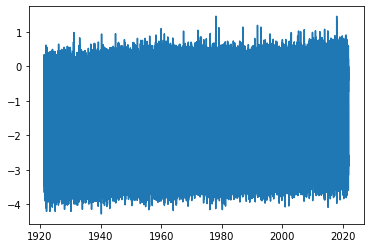

In [13]:
def plot_historical_tide(sta_id, path=save_path+f'{country}/'):
    df = pd.read_pickle(path+f'{sta_id}/tide_guage.pickle')
    plt.plot(df.index, df['obs'])
    
plot_historical_tide(station_ids[1])

## 2.